In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torchsummary import summary

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn import tree
from math import floor, ceil

import sklearn
import shap
shap.initjs()
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import plot_tree
import graphviz
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import precision_recall_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import Lasso,Ridge,BayesianRidge,ElasticNet,HuberRegressor,LinearRegression,LogisticRegression,SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.cluster import k_means
from sklearn.cluster import KMeans

from sklearn.metrics import r2_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score, precision_score , recall_score , confusion_matrix
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings
warnings.filterwarnings("ignore")

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

### Reading data
The data consists of 7 columns, namely...

In [2]:
data_frame = pd.read_csv('Admission_Predict_Ver1.1.csv')

### Inspecting the data

In [3]:
print("Data shape is ", data_frame.shape, "\n")
data_frame.head().T

Data shape is  (500, 9) 



,0,1,2,3,4
Serial No.,1.00,2.00,3.00,4.00,5.00
GRE Score,337.00,324.00,316.00,322.00,314.00
TOEFL Score,118.00,107.00,104.00,110.00,103.00
University Rating,4.00,4.00,3.00,3.00,2.00
SOP,4.50,4.00,3.00,3.50,2.00
LOR,4.50,4.50,3.50,2.50,3.00
CGPA,9.65,8.87,8.00,8.67,8.21
Research,1.00,1.00,1.00,1.00,0.00
Chance of Admit,0.92,0.76,0.72,0.80,0.65


### Dropping extra columns

In [4]:
data_frame['LOR'] = data_frame['LOR ']
data_frame['Chance of Admit'] = data_frame['Chance of Admit ']
data_frame.drop(columns=["Serial No.", "LOR ", "Chance of Admit "], inplace=True)
data_frame.shape

(500, 8)

In [5]:
data_frame.describe().T

,count,mean,std,min,25%,50%,75%,max
GRE Score,500.0,316.47200,11.295148,290.00,308.0000,317.00,325.00,340.00
TOEFL Score,500.0,107.19200,6.081868,92.00,103.0000,107.00,112.00,120.00
University Rating,500.0,3.11400,1.143512,1.00,2.0000,3.00,4.00,5.00
SOP,500.0,3.37400,0.991004,1.00,2.5000,3.50,4.00,5.00
CGPA,500.0,8.57644,0.604813,6.80,8.1275,8.56,9.04,9.92
Research,500.0,0.56000,0.496884,0.00,0.0000,1.00,1.00,1.00
LOR,500.0,3.48400,0.925450,1.00,3.0000,3.50,4.00,5.00
Chance of Admit,500.0,0.72174,0.141140,0.34,0.6300,0.72,0.82,0.97


### Inspecting distribution of data

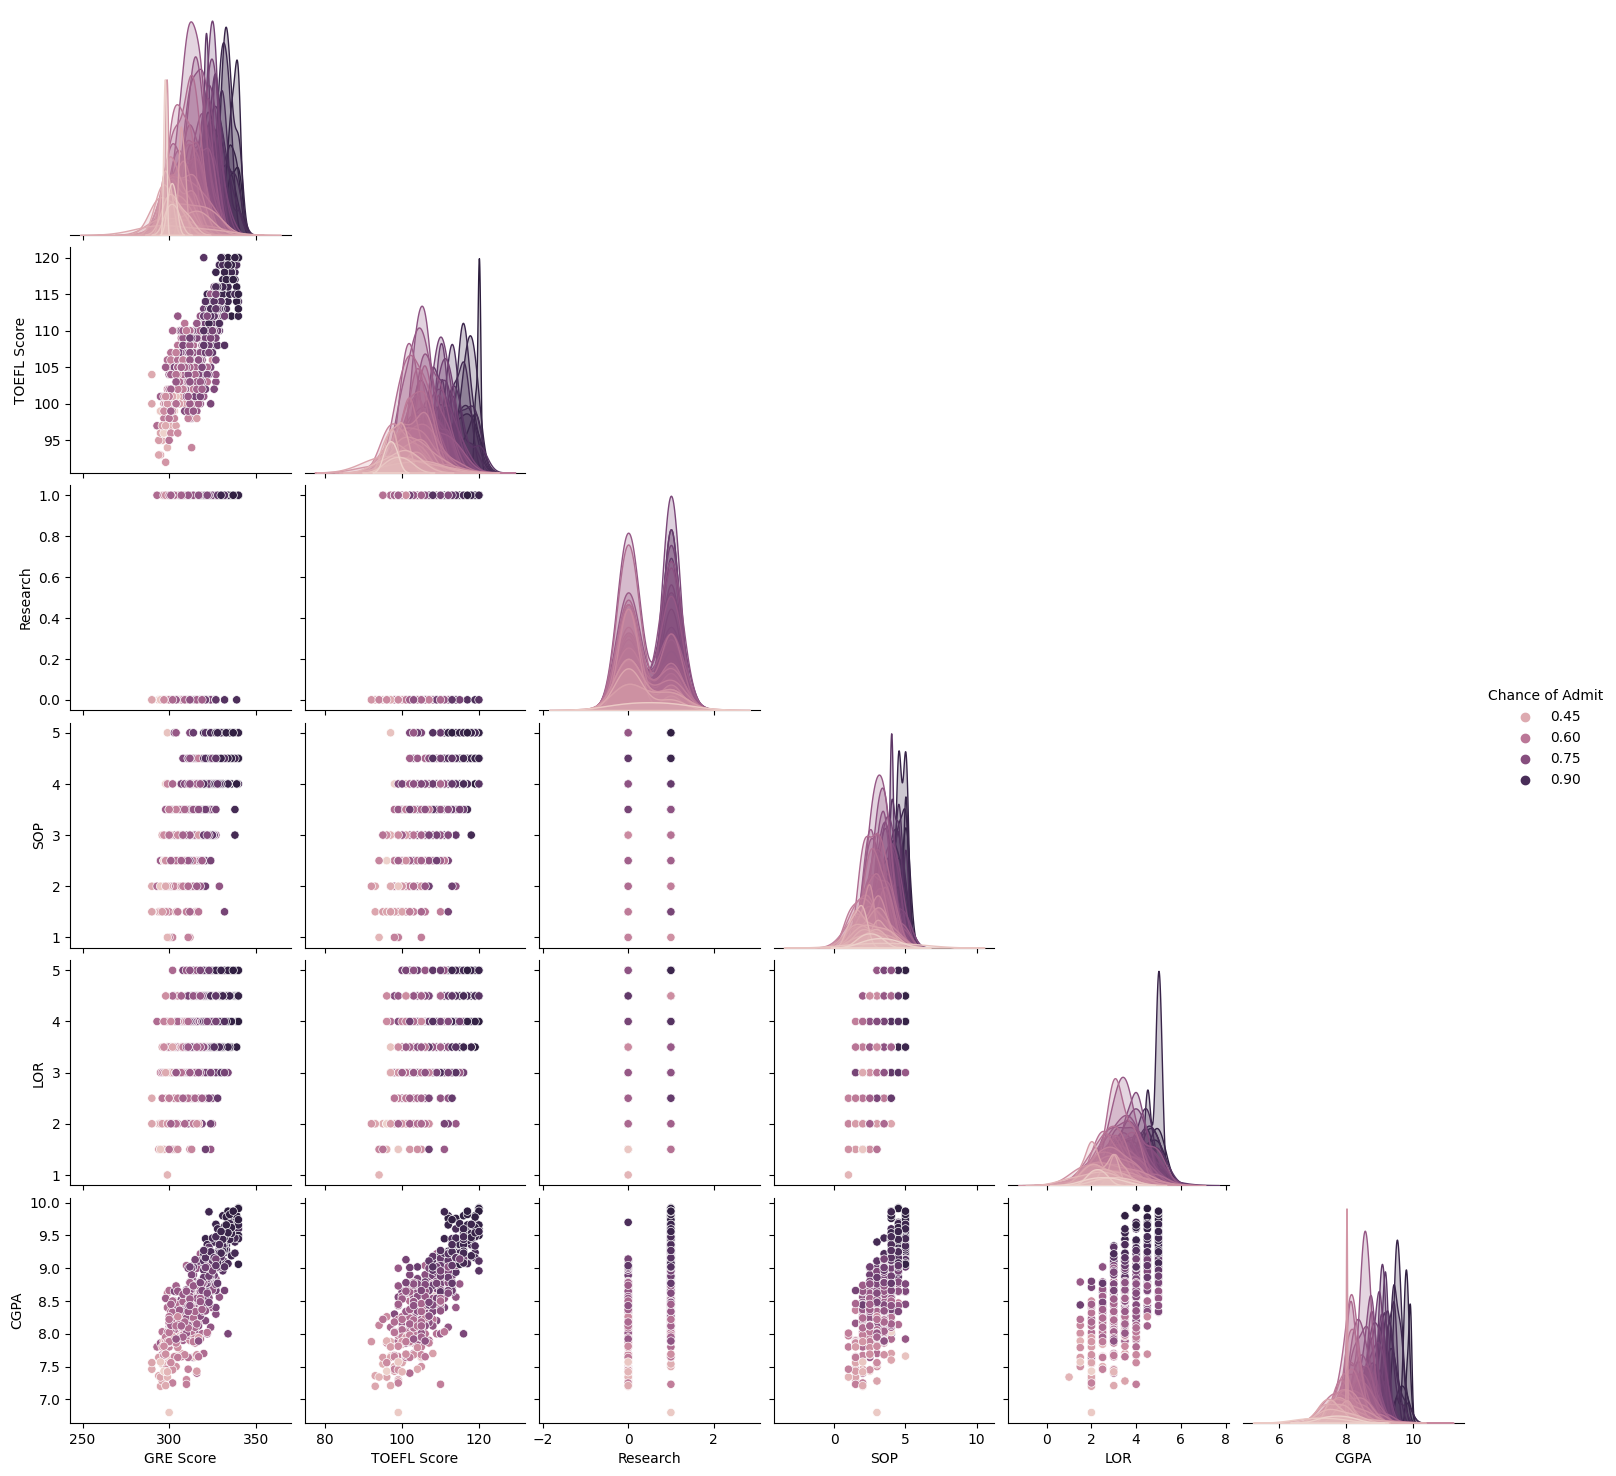

In [6]:
sns.pairplot(data_frame, vars=['GRE Score', 'TOEFL Score', 'Research', 'SOP', 'LOR', 'CGPA'], hue='Chance of Admit', corner=True)

### Finding the correlation

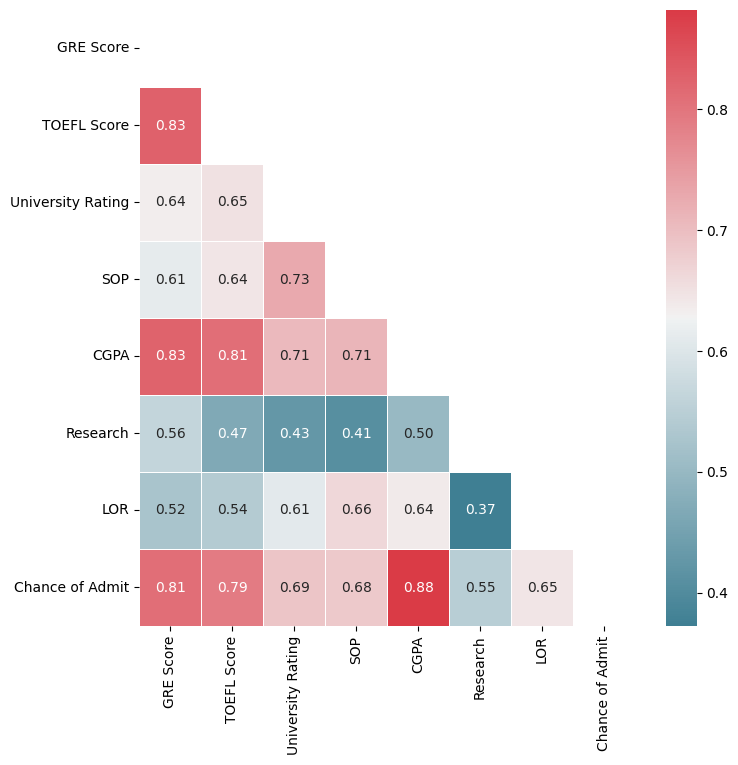

In [7]:
correlations = data_frame.corr()
fig, ax = plt.subplots(figsize=(8, 8))
colormap = sns.diverging_palette(220, 10, as_cmap=True)
dropSelf = np.zeros_like(correlations)
dropSelf[np.triu_indices_from(dropSelf)] = True
colormap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(correlations, cmap=colormap, linewidths=.5, annot=True, fmt=".2f", mask=dropSelf)
plt.show()

### Checking the data distribution

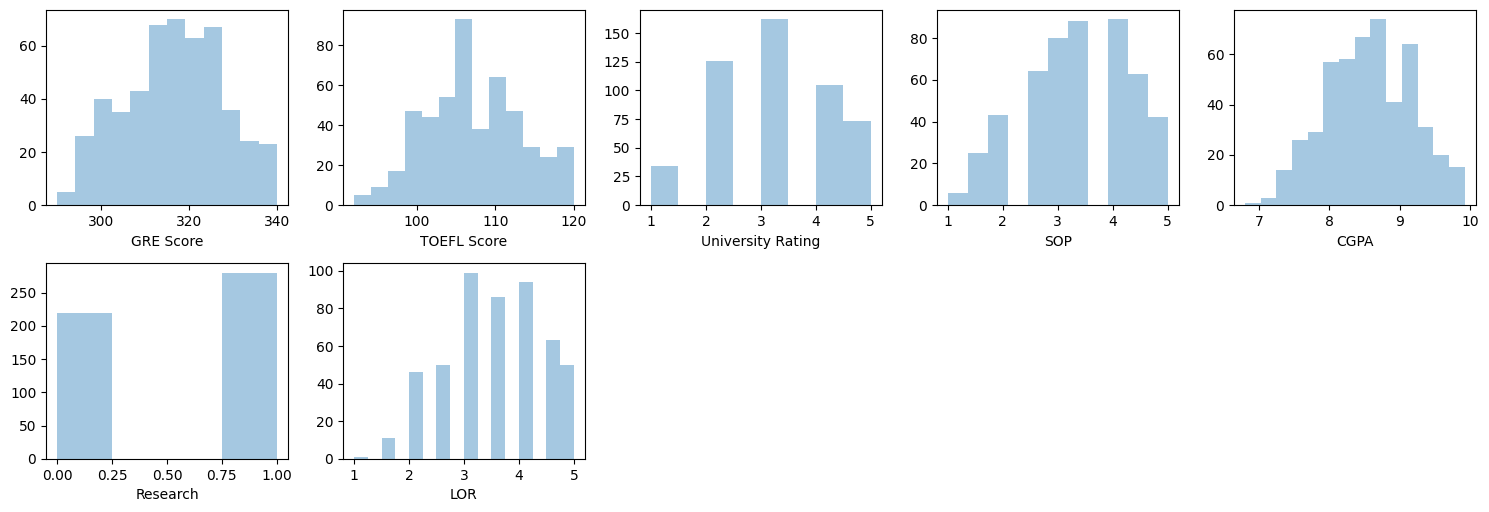

In [8]:
plt.figure(figsize=(15,20))
plotnumber = 1

for column in data_frame:
    if column != 'Chance of Admit':
        plt.subplot(8, 5, plotnumber)
        sns.distplot(data_frame[column], kde=False)
    plotnumber += 1

plt.tight_layout()
plt.show()

### Plotting the correlation of each feature w.r.t. the chance of admission

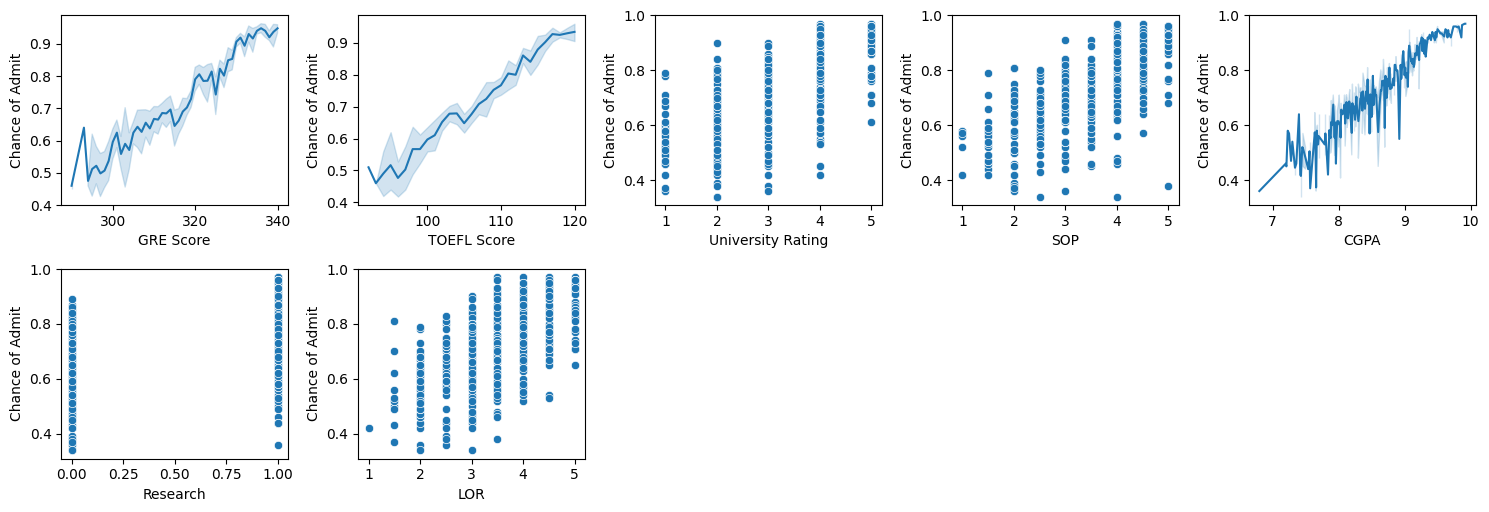

In [9]:
column_class = {}
column_class['continuous'] = ['GRE Score', 'TOEFL Score', 'CGPA']
column_class['discrete'] = ['University Rating', 'SOP', 'Research', 'LOR']

plt.figure(figsize=(15,20))
plotnumber = 1

for column in data_frame:
    if column != 'Chance of Admit':
        plt.subplot(8, 5, plotnumber)
        if column in column_class['discrete']:
            sns.scatterplot(data_frame, x=column, y='Chance of Admit')
        else:
            sns.lineplot(data_frame, x=column, y='Chance of Admit')
    plotnumber+=1

plt.tight_layout()
plt.show()

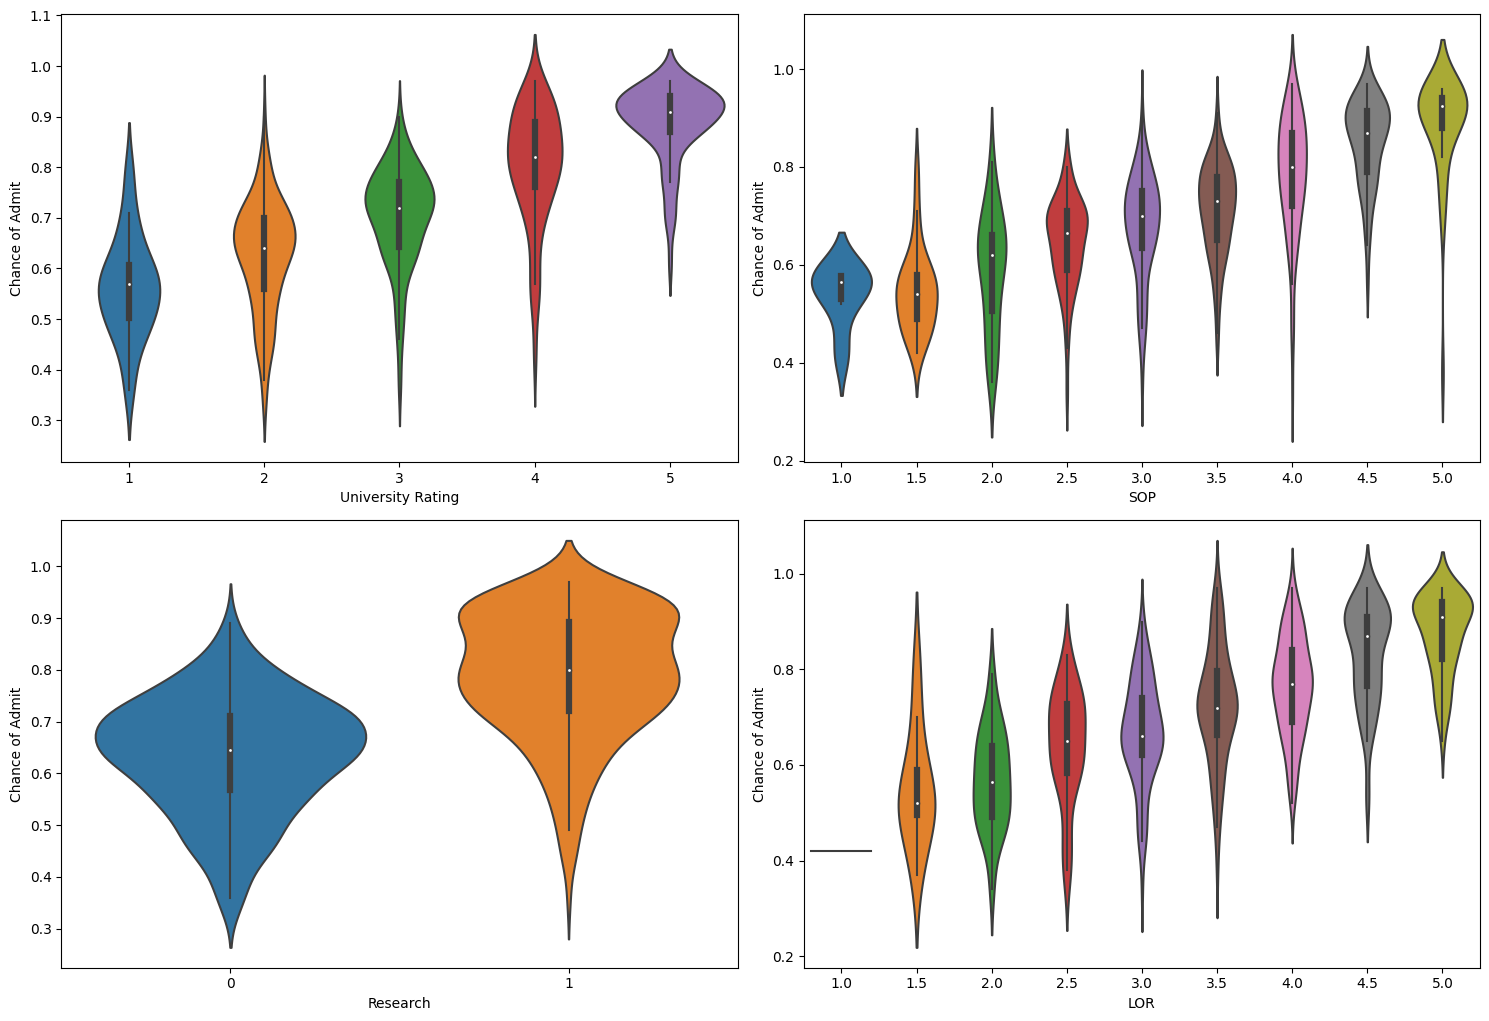

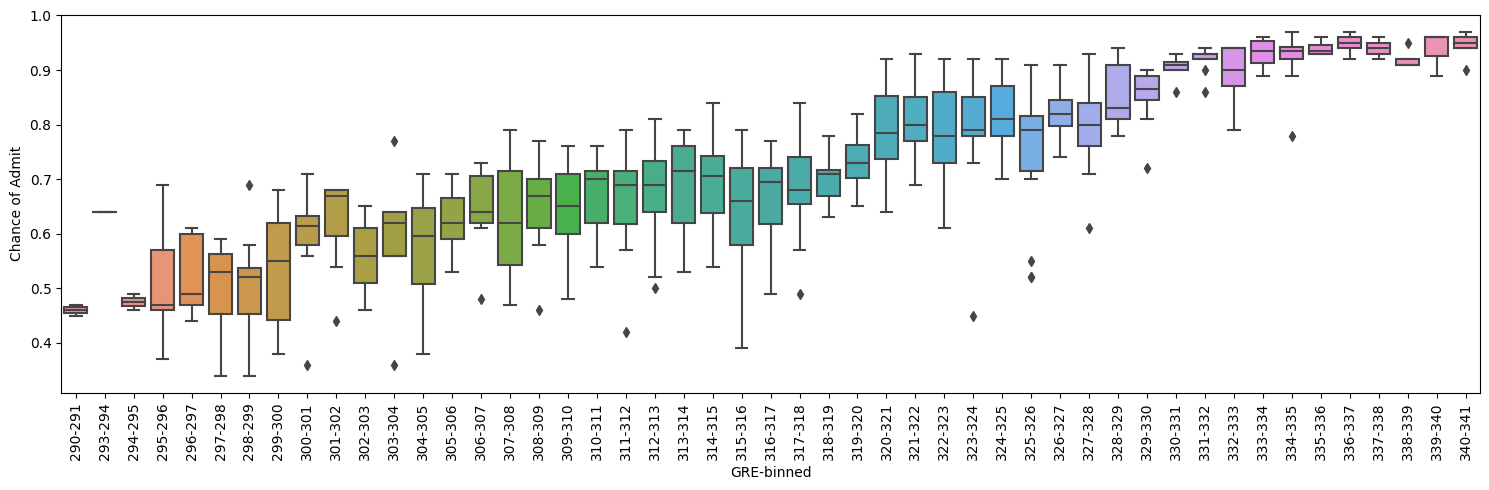

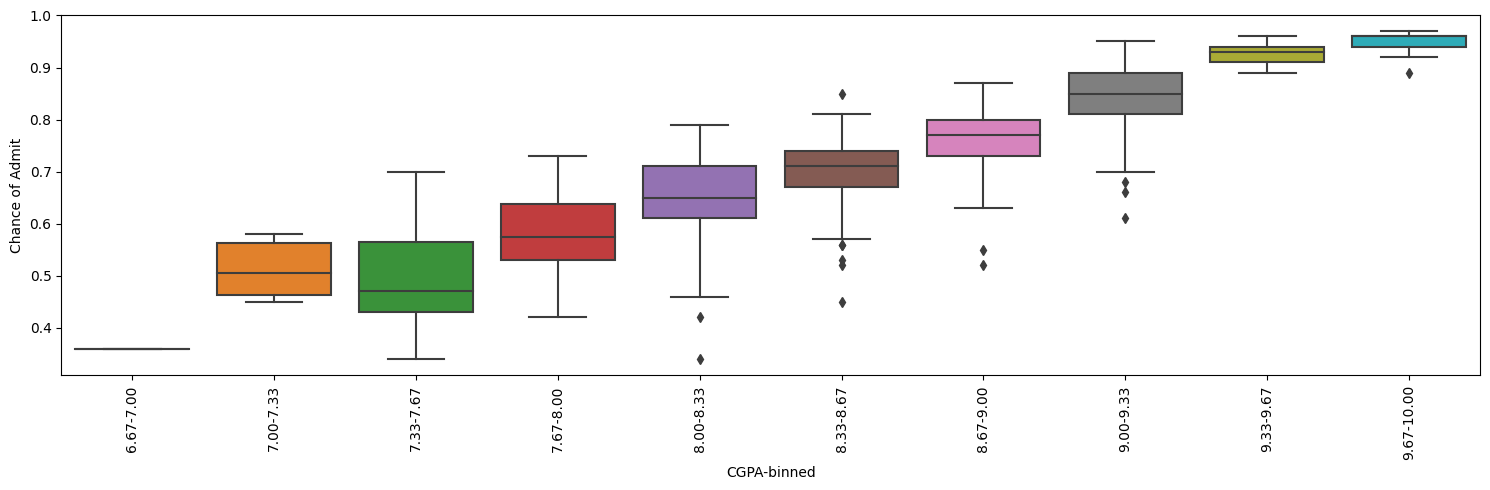

In [10]:
plt.figure(figsize=(15,20))
plotnumber = 1

for column in data_frame:
    if column != 'Chance of Admit':
        if column in column_class['discrete']:
            plt.subplot(4, 2, plotnumber)
            sns.violinplot(data_frame, x=column, y='Chance of Admit')
            plotnumber+=1

plt.tight_layout()
plt.show()

binning_factor_gre = 1

def bin_gre(gre_score):
    lower_bound = floor(gre_score / binning_factor_gre)
    upper_bound = ceil(gre_score / binning_factor_gre)
    if lower_bound == upper_bound:
        upper_bound += 1
    return format((lower_bound * binning_factor_gre), ".0f") + "-" + format((upper_bound * binning_factor_gre), ".0f")

df = data_frame.copy()
df['GRE-binned'] = df['GRE Score'].apply(bin_gre)


plt.figure(figsize=(15,5))
sns.boxplot(df, x='GRE-binned', y='Chance of Admit', order=df.sort_values('GRE-binned', ascending=True)['GRE-binned'].unique())
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

binning_factor_cgpa = 1/3

def bin_cgpa(cgpa):
    lower_bound = floor(cgpa / binning_factor_cgpa)
    upper_bound = ceil(cgpa / binning_factor_cgpa)
    if lower_bound == upper_bound:
        upper_bound += 1
    return format((lower_bound * binning_factor_cgpa), ".2f") + "-" + format((upper_bound * binning_factor_cgpa), ".2f")

df = data_frame.copy()
df['CGPA-binned'] = df['CGPA'].apply(bin_cgpa)

plt.figure(figsize=(15,5))
sns.boxplot(df, x='CGPA-binned', y='Chance of Admit', order=df.sort_values('CGPA-binned', ascending=True)['CGPA-binned'].unique())
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## Test Train split

In [11]:
df = pd.read_csv('Admission_Predict_Ver1.1.csv')
df.drop(columns=["Serial No."], inplace=True)
data = df.iloc[:,0:-1]
data.shape
labels = df.iloc[:,-1]
labels.shape

(500,)

In [12]:
scaler = MinMaxScaler()
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=50)
train_data_scaled = pd.DataFrame(scaler.fit_transform(train_data), index=train_data.index, columns=train_data.columns)
test_data_scaled = pd.DataFrame(scaler.fit_transform(test_data), index=test_data.index, columns=test_data.columns)

In [13]:
models = [['DecisionTree',DecisionTreeRegressor(max_depth=5)],
           ['Linear Regression', LinearRegression()],
           ['RandomForest',RandomForestRegressor(max_depth=5)],
           ['AdaBoostClassifier', AdaBoostRegressor()],
           ['CatBoost', CatBoostRegressor(max_depth=5)],
           ['Ridge', Ridge()]
         ]

## Fit regression models

In [14]:
def plot_importance(features, importance_1, importance_2, model_1_name, model_2_name, plotnumber):
    plt.subplot(10, 3, plotnumber)
    sum = importance_1.sum()
    importance = [imp * 100.0 / sum for imp in importance_1]
    importance_frame = pd.DataFrame()
    importance_frame['Features'] = features
    importance_frame['Importance'] = importance
    importance_frame = importance_frame.sort_values(by=['Importance'], ascending=True)
    
    plt.barh([1,2,3,4,5,6,7], importance_frame['Importance'], align='center', alpha=0.5)

    plt.subplot(10, 3, plotnumber)
    sum = importance_2.sum()
    importance = [imp * 100.0 / sum for imp in importance_2]
    importance_frame = pd.DataFrame()
    importance_frame['Features'] = features
    importance_frame['Importance'] = importance
    importance_frame = importance_frame.sort_values(by=['Importance'], ascending=True)
    
    plt.barh([1,2,3,4,5,6,7], importance_frame['Importance'], align='center', alpha=0.5)
    plt.yticks([1,2,3,4,5,6,7], importance_frame['Features'], rotation=45)
    plt.legend([model_1_name, model_2_name])
    plt.title(name)

def fit_model_and_plot_results(model, plotnumber):
    model.fit(train_data, train_labels)
    predictions_unscaled = model.predict(test_data)
    rmse_unscaled = np.sqrt(mean_squared_error(test_labels, predictions_unscaled))
    r2score_unscaled = r2_score(y_true=test_labels, y_pred=predictions_unscaled)
    unscaled_coeff = None
    unscaled_importance = None
    shap_values_unscaled = None
    
    try:
        explainer = shap.KernelExplainer(model.predict, train_data, keep_index=True)
        shap_values_unscaled = explainer(train_data)
    except Exception as e:
        print(e)

    try:
        unscaled_coeff = model.coef_
    except Exception as e:
        pass

    try:
        unscaled_importance = model.feature_importances_
    except Exception as e:
        pass
    
    model.fit(train_data_scaled, train_labels)
    predictions_scaled = model.predict(test_data_scaled)
    rmse_scaled = np.sqrt(mean_squared_error(test_labels, predictions_scaled))
    r2score_scaled = r2_score(y_true=test_labels, y_pred=predictions_scaled)
    scaled_coeff = None
    scaled_importance = None
    shap_values_scaled = None
    
    try:
        explainer = shap.KernelExplainer(model.predict, train_data_scaled, keep_index=True)
        shap_values_scaled = explainer(train_data_scaled)
    except Exception as e:
        pass

    try:
        scaled_coeff = model.coef_
    except Exception as e:
        pass

    try:
        scaled_importance = model.feature_importances_
    except Exception as e:
        pass
    
    try:
        plot_importance(train_data_scaled.columns, unscaled_coeff, scaled_coeff, "unscaled", "scaled", plotnumber)
    except Exception as e:
        pass
    
    try:
        plot_importance(train_data.columns, unscaled_importance, scaled_importance, "unscaled", "scaled", plotnumber)
    except Exception as e:
        pass

    try:
        ax=plt.subplot(10, 3,plotnumber+1)
        shap.summary_plot(shap_values_scaled, train_data_scaled, plot_size=(20, 30))
    except Exception as e:
        pass
    
    return rmse_scaled, rmse_unscaled, r2score_scaled, r2score_unscaled, 3

Using 400 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/400 [00:00<?, ?it/s]

Using 400 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/400 [00:00<?, ?it/s]

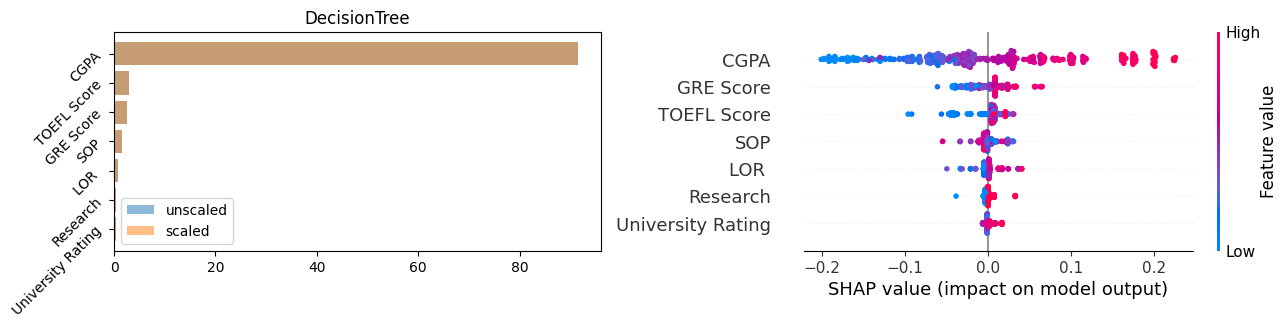

Using 400 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/400 [00:00<?, ?it/s]

Using 400 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/400 [00:00<?, ?it/s]

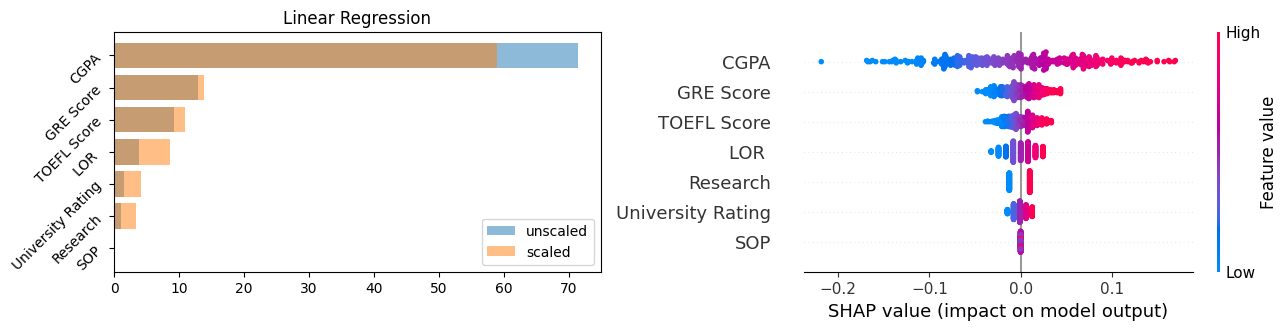

Using 400 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/400 [00:00<?, ?it/s]

Using 400 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/400 [00:00<?, ?it/s]

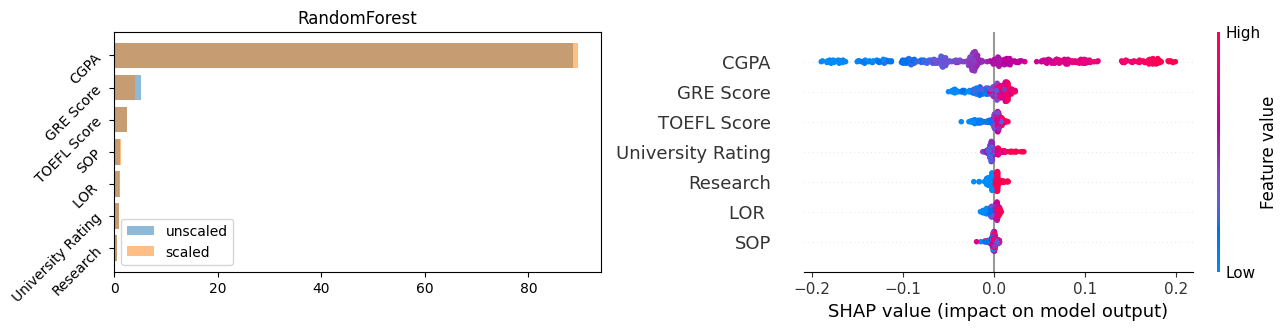

Using 400 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/400 [00:00<?, ?it/s]

Using 400 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/400 [00:00<?, ?it/s]

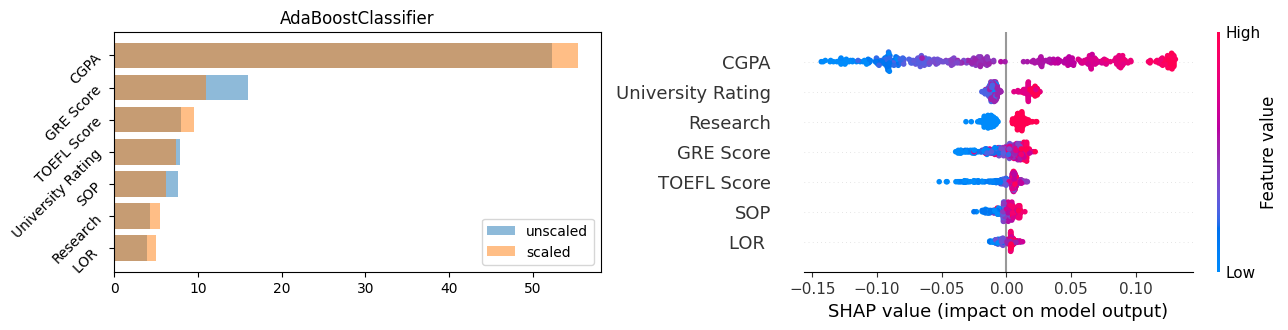

Learning rate set to 0.035425
0:	learn: 0.1370357	total: 47.9ms	remaining: 47.9s
1:	learn: 0.1339514	total: 48.2ms	remaining: 24.1s
2:	learn: 0.1306651	total: 48.5ms	remaining: 16.1s
3:	learn: 0.1275566	total: 48.7ms	remaining: 12.1s
4:	learn: 0.1248278	total: 48.9ms	remaining: 9.73s
5:	learn: 0.1221283	total: 49.1ms	remaining: 8.13s
6:	learn: 0.1196106	total: 49.3ms	remaining: 6.99s
7:	learn: 0.1170562	total: 49.5ms	remaining: 6.14s
8:	learn: 0.1146013	total: 49.7ms	remaining: 5.47s
9:	learn: 0.1122578	total: 49.9ms	remaining: 4.94s
10:	learn: 0.1099932	total: 50ms	remaining: 4.5s
11:	learn: 0.1077260	total: 50.2ms	remaining: 4.13s
12:	learn: 0.1055337	total: 50.4ms	remaining: 3.83s
13:	learn: 0.1036563	total: 50.6ms	remaining: 3.56s
14:	learn: 0.1016509	total: 50.8ms	remaining: 3.33s
15:	learn: 0.0996831	total: 51ms	remaining: 3.13s
16:	learn: 0.0980762	total: 51.1ms	remaining: 2.96s
17:	learn: 0.0964429	total: 51.3ms	remaining: 2.8s
18:	learn: 0.0948004	total: 51.5ms	remaining: 2.66

Using 400 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


727:	learn: 0.0317814	total: 182ms	remaining: 67.9ms
728:	learn: 0.0317567	total: 182ms	remaining: 67.6ms
729:	learn: 0.0317029	total: 182ms	remaining: 67.3ms
730:	learn: 0.0316945	total: 182ms	remaining: 67.1ms
731:	learn: 0.0316726	total: 182ms	remaining: 66.8ms
732:	learn: 0.0316610	total: 183ms	remaining: 66.5ms
733:	learn: 0.0316521	total: 183ms	remaining: 66.3ms
734:	learn: 0.0316066	total: 183ms	remaining: 66ms
735:	learn: 0.0315951	total: 183ms	remaining: 65.7ms
736:	learn: 0.0315920	total: 183ms	remaining: 65.5ms
737:	learn: 0.0315155	total: 184ms	remaining: 65.2ms
738:	learn: 0.0314960	total: 184ms	remaining: 64.9ms
739:	learn: 0.0314573	total: 184ms	remaining: 64.6ms
740:	learn: 0.0314496	total: 184ms	remaining: 64.4ms
741:	learn: 0.0314379	total: 184ms	remaining: 64.1ms
742:	learn: 0.0313971	total: 185ms	remaining: 63.8ms
743:	learn: 0.0313895	total: 185ms	remaining: 63.6ms
744:	learn: 0.0313855	total: 185ms	remaining: 63.3ms
745:	learn: 0.0313717	total: 185ms	remaining: 63

  0%|          | 0/400 [00:00<?, ?it/s]

Learning rate set to 0.035425
0:	learn: 0.1370357	total: 946us	remaining: 946ms
1:	learn: 0.1339514	total: 1.19ms	remaining: 592ms
2:	learn: 0.1306651	total: 1.43ms	remaining: 475ms
3:	learn: 0.1275566	total: 1.65ms	remaining: 412ms
4:	learn: 0.1248278	total: 1.89ms	remaining: 376ms
5:	learn: 0.1221283	total: 2.11ms	remaining: 349ms
6:	learn: 0.1196106	total: 2.35ms	remaining: 333ms
7:	learn: 0.1170562	total: 2.57ms	remaining: 319ms
8:	learn: 0.1146013	total: 2.8ms	remaining: 308ms
9:	learn: 0.1122578	total: 3.01ms	remaining: 298ms
10:	learn: 0.1099932	total: 3.23ms	remaining: 291ms
11:	learn: 0.1077260	total: 3.45ms	remaining: 284ms
12:	learn: 0.1055337	total: 3.66ms	remaining: 278ms
13:	learn: 0.1036563	total: 3.88ms	remaining: 273ms
14:	learn: 0.1016509	total: 4.09ms	remaining: 269ms
15:	learn: 0.0996831	total: 4.32ms	remaining: 266ms
16:	learn: 0.0980762	total: 4.55ms	remaining: 263ms
17:	learn: 0.0964429	total: 4.77ms	remaining: 260ms
18:	learn: 0.0948004	total: 5ms	remaining: 258

Using 400 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


911:	learn: 0.0275694	total: 179ms	remaining: 17.3ms
912:	learn: 0.0275540	total: 179ms	remaining: 17.1ms
913:	learn: 0.0275450	total: 179ms	remaining: 16.9ms
914:	learn: 0.0275397	total: 180ms	remaining: 16.7ms
915:	learn: 0.0275302	total: 180ms	remaining: 16.5ms
916:	learn: 0.0275164	total: 180ms	remaining: 16.3ms
917:	learn: 0.0275115	total: 180ms	remaining: 16.1ms
918:	learn: 0.0274936	total: 180ms	remaining: 15.9ms
919:	learn: 0.0274562	total: 180ms	remaining: 15.7ms
920:	learn: 0.0274267	total: 181ms	remaining: 15.5ms
921:	learn: 0.0274039	total: 181ms	remaining: 15.3ms
922:	learn: 0.0273859	total: 181ms	remaining: 15.1ms
923:	learn: 0.0273691	total: 181ms	remaining: 14.9ms
924:	learn: 0.0273461	total: 181ms	remaining: 14.7ms
925:	learn: 0.0273408	total: 182ms	remaining: 14.5ms
926:	learn: 0.0273256	total: 182ms	remaining: 14.3ms
927:	learn: 0.0273144	total: 182ms	remaining: 14.1ms
928:	learn: 0.0272998	total: 182ms	remaining: 13.9ms
929:	learn: 0.0272849	total: 182ms	remaining: 

  0%|          | 0/400 [00:00<?, ?it/s]

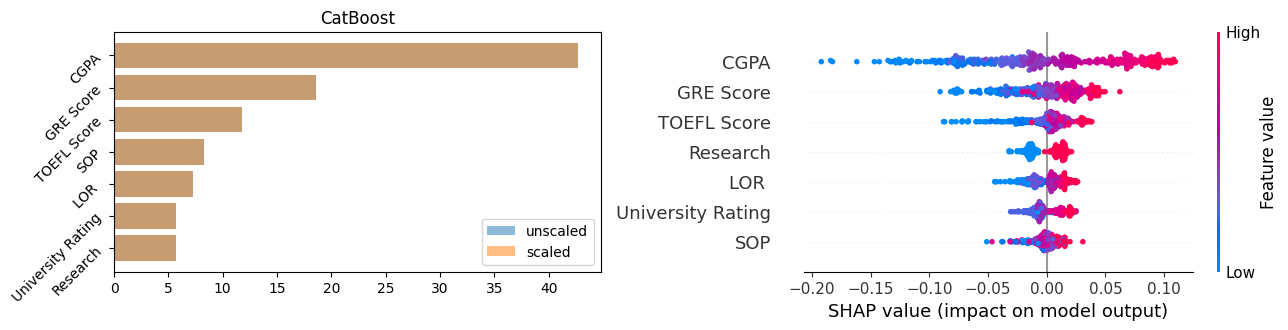

Using 400 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/400 [00:00<?, ?it/s]

Using 400 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/400 [00:00<?, ?it/s]

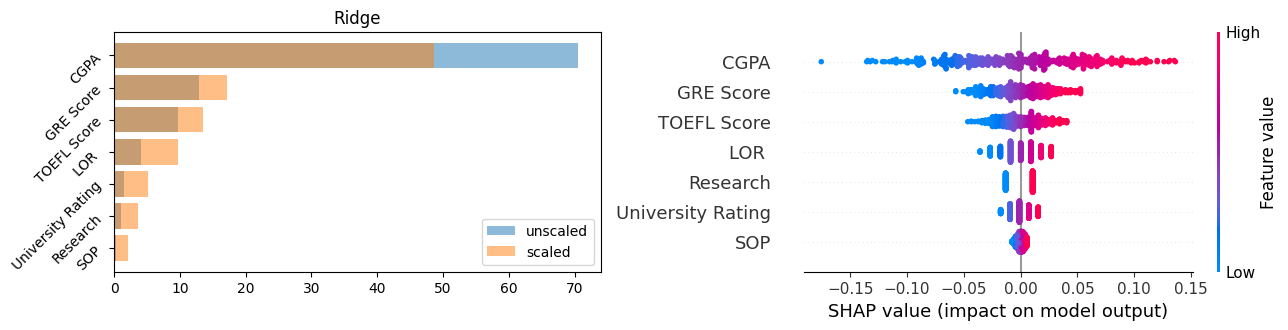

In [15]:
plt.figure(figsize=(15,50))
plotnumber = 1
rmse = []
rmse_scaled = []
rmse_unscaled = []
r2_scaled = []
r2_unscaled = []
for name, model in models:
    rmse_scaled_val, rmse_unscaled_val, r2score_scaled, r2score_unscaled, n_graphs = fit_model_and_plot_results(model, plotnumber)
    plotnumber += n_graphs
    rmse.append((name, rmse_scaled_val))
    rmse.append((name, rmse_unscaled_val))
    rmse_scaled.append((name, rmse_scaled_val))
    rmse_unscaled.append((name, rmse_unscaled_val))
    r2_scaled.append((name, r2score_scaled))
    r2_unscaled.append((name, r2score_unscaled))

## ANN

In [16]:
train_data_torch = torch.tensor(train_data_scaled.to_numpy()).to(device)
train_labels_torch = torch.tensor(train_labels.to_numpy()).to(device)

valid_data_torch = torch.tensor(test_data_scaled.to_numpy()).to(device)
valid_labels_torch = torch.tensor(test_labels.to_numpy()).to(device)

def save_model(model):
    from torch import save
    from os import path
    return save(model.state_dict(), "model.th")

def load_model():
    from torch import load
    from os import path
    r = Model()
    r.load_state_dict(load("model.th", map_location='cpu'))
    return r

class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.input_dimens = 7
        self.output_dimens = 1
        self.layers = [50, 100]
        model_layers = []
        current_layer = self.input_dimens
        for layer in self.layers:
            model_layers.append(torch.nn.Linear(current_layer, layer))
            model_layers.append(torch.nn.ReLU())
            current_layer = layer
        model_layers.append(torch.nn.Linear(current_layer, self.output_dimens))

        self.model_layers = torch.nn.Sequential(*model_layers)

    def forward(self, data):
        return self.model_layers(data.type(torch.float))[:, 0]

In [17]:
model = Model().to(device)
print(summary(model, input_size=(7,), batch_size=10))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [10, 50]             400
              ReLU-2                   [10, 50]               0
            Linear-3                  [10, 100]           5,100
              ReLU-4                  [10, 100]               0
            Linear-5                    [10, 1]             101
Total params: 5,601
Trainable params: 5,601
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 0.02
Estimated Total Size (MB): 0.04
----------------------------------------------------------------
None


## Training code

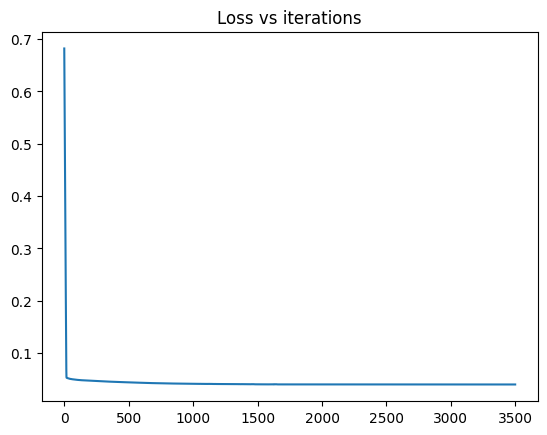

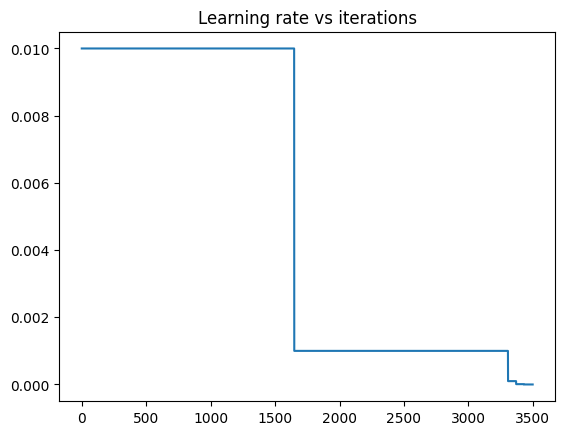

In [129]:
model = Model().to(device)
epochs = 3500
learning_rate = 0.01
loss = torch.nn.L1Loss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=58)

losses = []
lr_history = []

for epoch in range(epochs):
    predictions = model(train_data_torch)
    total_loss = loss(input=predictions, target=train_labels_torch)
    
    losses.append(total_loss.item())
    lr_history.append(optimizer.param_groups[0]['lr'])
    
    total_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    scheduler.step(total_loss)

plt.plot(losses)
plt.title("Loss vs iterations")
plt.show()
plt.plot(lr_history)
plt.title("Learning rate vs iterations")
plt.show()

save_model(model)

## Evaluating performance of ANN

0.060485844453573634
0.0036585373792619043
0.8209334477698816


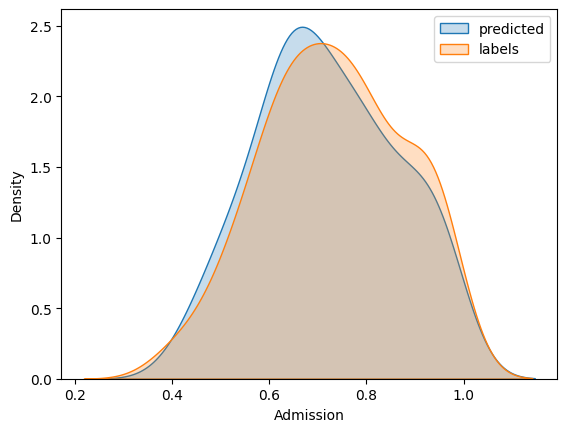

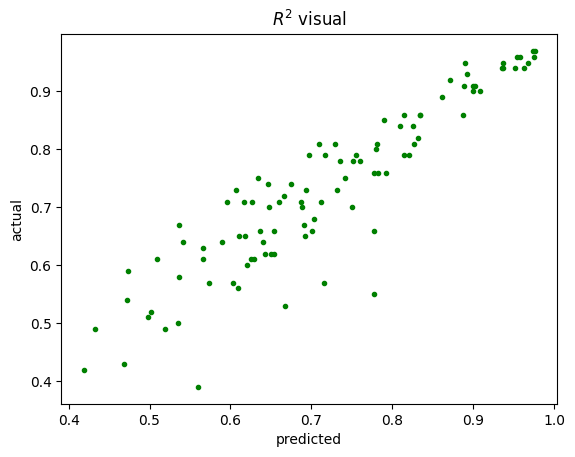

In [18]:
model = load_model().to(device)

valid_predictions = model(valid_data_torch)
rmse_ann = np.sqrt(mean_squared_error(valid_labels_torch.cpu().detach(), valid_predictions.cpu().detach()))
print(rmse_ann)
print(rmse_ann**2)
r2score_ann = r2_score(y_true=valid_labels_torch.cpu().detach(), y_pred=valid_predictions.cpu().detach())
print(r2score_ann)

sns.kdeplot(valid_predictions.cpu().detach().squeeze(), label='estimate', shade=True)
sns.kdeplot(valid_labels_torch.cpu().detach().squeeze(), label='true', shade=True)
plt.legend(["predicted", "labels"])
plt.xlabel('Admission')
plt.show()

plt.plot(valid_predictions.cpu().detach(), valid_labels_torch.cpu().detach(), 'g.')
plt.xlabel('predicted')
plt.ylabel('actual')
plt.title('$R^{2}$ visual');
plt.show()

## Comparison of model performance

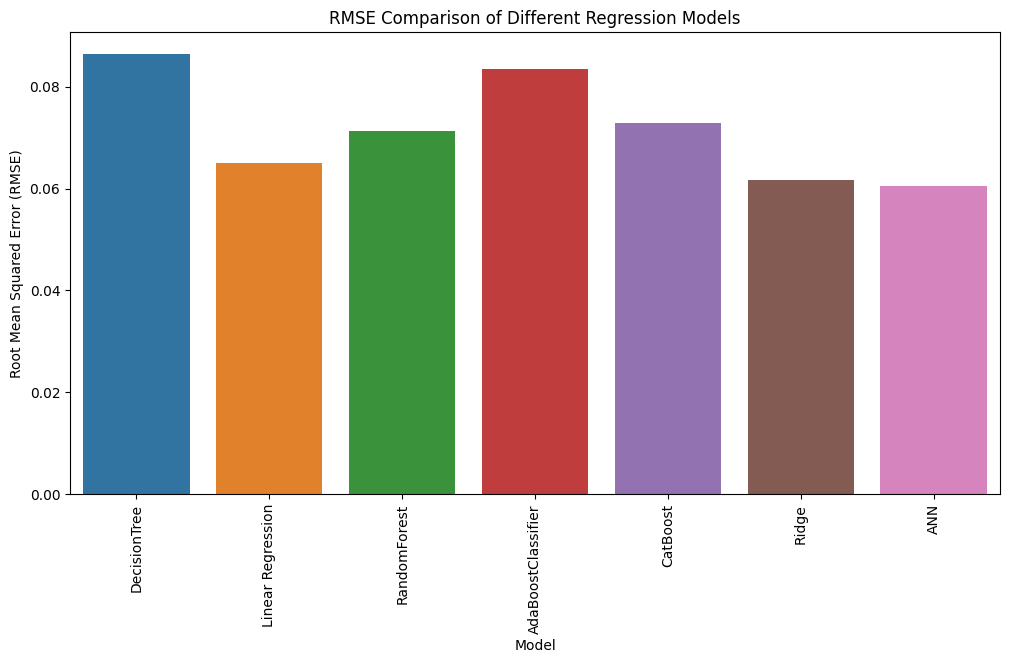

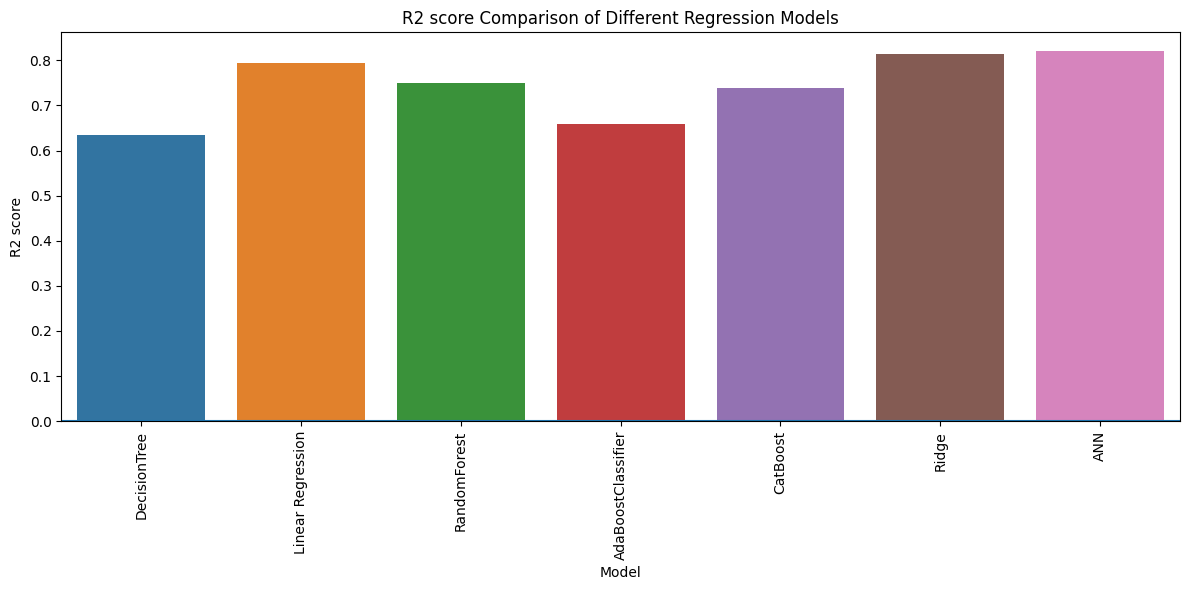

In [19]:
results_df = pd.DataFrame(rmse_scaled, columns=['Model', 'RMSE'])
r2_df = pd.DataFrame(r2_scaled, columns=['Model', 'R2 score'])
diff = pd.DataFrame([(rmse_scaled[i][0], rmse_scaled[i][1] - rmse_unscaled[i][1]) for i in range(len(rmse_scaled))], columns=['Model', 'RMSE'])

results_df.loc[len(results_df.index)] = ['ANN', rmse_ann] 
r2_df.loc[len(r2_df.index)] = ['ANN', r2score_ann] 

plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='RMSE', data=results_df)
plt.xticks(rotation=90)
plt.xlabel('Model')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.title('RMSE Comparison of Different Regression Models')


plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='R2 score', data=r2_df)
plt.xticks(rotation=90)
plt.xlabel('Model')
plt.axhline(0.0)
plt.ylabel('R2 score')
plt.title('R2 score Comparison of Different Regression Models')

plt.tight_layout()
plt.show()

In [20]:
model_comparison = results_df.copy()
model_comparison['R2 score'] = r2_df['R2 score']
model_comparison

,Model,RMSE,R2 score
0,DecisionTree,0.086375,0.634838
1,Linear Regression,0.065030,0.793020
2,RandomForest,0.071384,0.750590
3,AdaBoostClassifier,0.083553,0.658310
4,CatBoost,0.072945,0.739568
5,Ridge,0.061625,0.814127
6,ANN,0.060486,0.820933


## Finding features of ANN

In [21]:
explainer = shap.DeepExplainer(model, train_data_torch[:, None, :].to(device))
values = explainer.shap_values(train_data_torch[:, None, :])
shap.force_plot(explainer.expected_value[:], values.squeeze(1)[:])

## PCA

In [14]:
pca = PCA(n_components=7)
pca.fit(train_data)
train_data_PCA = pca.transform(train_data)
train_data_PCA = pd.DataFrame(train_data_PCA)
train_data_PCA

variance_ratios = np.array(pca.explained_variance_ratio_.cumsum())
pd.DataFrame(np.insert(pca.explained_variance_ratio_.cumsum(), 0, -1), columns=['No. of components'])[1:].T

,1,2,3,4,5,6,7
No. of components,0.93044,0.987552,0.994265,0.996824,0.998504,0.999542,1.0


## Training model with converted dimensional space

In [23]:
pca = PCA(n_components=3)
pca.fit(data)
data_PCA = pca.transform(data)
data_PCA = pd.DataFrame(data_PCA)

scaler = MinMaxScaler()
train_data_PCA, test_data_PCA, train_labels, test_labels = train_test_split(data_PCA, labels, test_size=0.2, random_state=42)
train_data_PCA_scaled = pd.DataFrame(scaler.fit_transform(train_data_PCA), index=train_data_PCA.index, columns=train_data_PCA.columns)
test_data_PCA_scaled = pd.DataFrame(scaler.fit_transform(test_data_PCA), index=test_data_PCA.index, columns=test_data_PCA.columns)

print(train_data_PCA.shape)
print(test_data_PCA.shape)

(400, 3)
(100, 3)


In [24]:
def fit_model_and_plot_results(model):
    model.fit(train_data_PCA, train_labels)
    predictions_unscaled = model.predict(test_data_PCA)
    rmse_unscaled = np.sqrt(mean_squared_error(test_labels, predictions_unscaled))
    r2score_unscaled = r2_score(y_true=test_labels, y_pred=predictions_unscaled)
    
    model.fit(train_data_PCA_scaled, train_labels)
    predictions_scaled = model.predict(test_data_PCA_scaled)
    rmse_scaled = np.sqrt(mean_squared_error(test_labels, predictions_scaled))
    r2score_scaled = r2_score(y_true=test_labels, y_pred=predictions_scaled)
    
    return rmse_scaled, rmse_unscaled, r2score_scaled, r2score_unscaled

In [28]:
rmse = []
rmse_scaled = []
rmse_unscaled = []
r2_scaled = []
r2_unscaled = []
print(models)
for name, model in models:
    rmse_scaled_val, rmse_unscaled_val, r2_scaled_val, r2_unscaled_val = fit_model_and_plot_results(model)
    rmse.append((name, rmse_scaled_val))
    rmse.append((name, rmse_unscaled_val))
    rmse_scaled.append((name, rmse_scaled_val))
    rmse_unscaled.append((name, rmse_unscaled_val))
    r2_scaled.append((name, r2_scaled_val))
    r2_unscaled.append((name, r2_unscaled_val))

[['DecisionTree', DecisionTreeRegressor(max_depth=5)], ['Linear Regression', LinearRegression()], ['RandomForest', RandomForestRegressor(max_depth=5)], ['AdaBoostClassifier', AdaBoostRegressor()], ['CatBoost', <catboost.core.CatBoostRegressor object at 0x7f1e041131f0>], ['Ridge', Ridge()]]
Learning rate set to 0.035425
0:	learn: 0.1377436	total: 689us	remaining: 688ms
1:	learn: 0.1348674	total: 976us	remaining: 487ms
2:	learn: 0.1320810	total: 1.23ms	remaining: 410ms
3:	learn: 0.1293915	total: 1.45ms	remaining: 360ms
4:	learn: 0.1271849	total: 1.65ms	remaining: 329ms
5:	learn: 0.1246505	total: 1.86ms	remaining: 308ms
6:	learn: 0.1223031	total: 2.06ms	remaining: 293ms
7:	learn: 0.1201053	total: 2.3ms	remaining: 285ms
8:	learn: 0.1178709	total: 2.54ms	remaining: 279ms
9:	learn: 0.1157880	total: 2.78ms	remaining: 276ms
10:	learn: 0.1140550	total: 3.02ms	remaining: 271ms
11:	learn: 0.1119166	total: 3.25ms	remaining: 268ms
12:	learn: 0.1100075	total: 3.48ms	remaining: 264ms
13:	learn: 0.108

## Comparing model performance with PCA

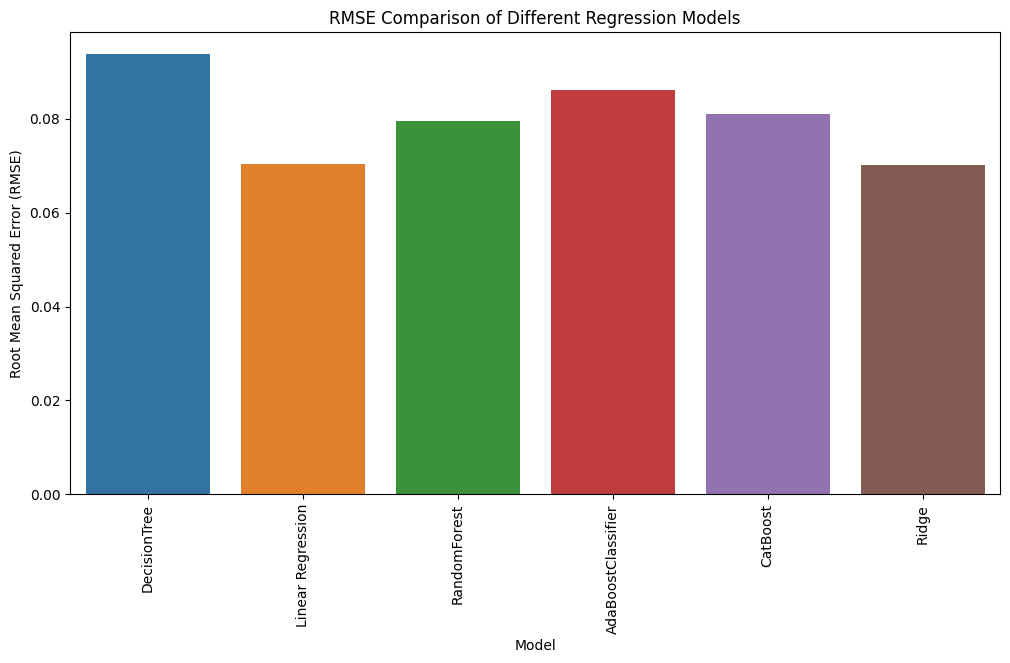

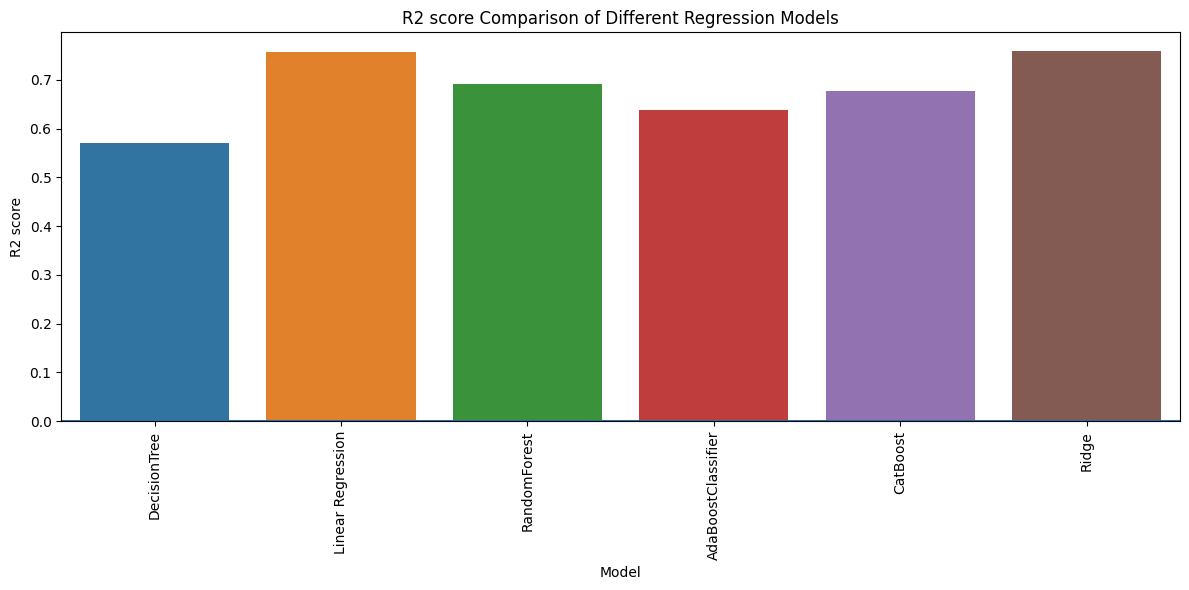

In [32]:
results_df = pd.DataFrame(rmse_scaled, columns=['Model', 'RMSE'])
r2_df = pd.DataFrame(r2_scaled, columns=['Model', 'R2 score'])
diff = pd.DataFrame([(rmse_scaled[i][0], rmse_scaled[i][1] - rmse_unscaled[i][1]) for i in range(len(rmse_scaled))], columns=['Model', 'RMSE'])

plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='RMSE', data=results_df)
plt.xticks(rotation=90)
plt.xlabel('Model')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.title('RMSE Comparison of Different Regression Models')


plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='R2 score', data=r2_df)
plt.xticks(rotation=90)
plt.xlabel('Model')
plt.axhline(0.0)
plt.ylabel('R2 score')
plt.title('R2 score Comparison of Different Regression Models')

plt.tight_layout()
plt.show()

In [33]:
model_comparison = results_df.copy()
model_comparison['R2 score'] = r2_df['R2 score']
model_comparison

,Model,RMSE,R2 score
0,DecisionTree,0.093759,0.570133
1,Linear Regression,0.070353,0.757967
2,RandomForest,0.079490,0.691022
3,AdaBoostClassifier,0.086070,0.637749
4,CatBoost,0.081126,0.678167
5,Ridge,0.070105,0.759671
